In [1]:
# Logging
import os
import sys
import wandb
from tensorboardX import SummaryWriter
import ast
# Config system
import hydra
from omegaconf import OmegaConf, DictConfig

# Utils
from tqdm import tqdm
import datetime
import time
from typing import Dict, Type, Any, Tuple
import cProfile

# ML libraries
import random
import numpy as np
import gym

# Project imports
from algorithms.base.base_algorithm import BaseRLAlgorithm


In [2]:
n_max_episodes_training = 5000
n_steps_exploration = 15 * n_max_episodes_training / 2

In [3]:

from algorithms.monte_carlo import MonteCarlo

config_mc = {
    "learning_rate": 0.1,
    "gamma": 0.99,
    "n_steps": "inf",
    "q_model": {
        "class_string": 'src.learners.tabular:QValuesTabularLearner',
        "method_q_value_initialization": "random",
        "typical_return": 1.0,
        "typical_return_std": 1.0
    },
    "method_exploration": "eps_greedy",
    "epsilon": {
        "class_string": "src.schedulers:Exponential",
        "start_value": 1.0,
        "end_value": 0.05,
        "n_steps": n_steps_exploration,
        "lower_bound": 0.05
    },
}

algo_mc = MonteCarlo(config_mc)

In [4]:
from environments.base_environment import BaseEnvironment

def train_algo(env : BaseEnvironment, algo : BaseRLAlgorithm):
    episode_train = 0
    list_episodic_rewards = []
    while episode_train < n_max_episodes_training:
        print(f"Episode {episode_train+1}/{n_max_episodes_training}",  end="\r")
        state, info = env.reset()
        available_actions = env.get_available_actions(state=state)
        done = False
        episodic_reward = 0
        step = 0
        while not done:
            # Act
            action = algo.act(
                    state=state,
                    available_actions=available_actions,
                    is_eval=False,
                )
            # Env step
            next_state, reward, is_trunc, done, info = env.step(action)
            next_available_actions = env.get_available_actions(state=next_state)
            # Learn
            algo.update(
                state=state, 
                action=action, 
                reward=reward, 
                next_state=next_state,
                done=done,
            )
            # Update the variables
            episodic_reward += reward
            state = next_state
            available_actions = next_available_actions
            step += 1
        list_episodic_rewards.append(episodic_reward)
        episode_train += 1
        
    return list_episodic_rewards


In [5]:
from environments.flappy_bird import FlappyBirdEnv
  
config_env = {
    "env_string": "TextFlappyBird-v0",
    "height": 15,
    "width": 20,
    "pipe_gap": 4,
    "do_add_last_action": False,
    "horizon": 400
}
env = FlappyBirdEnv(config_env)

In [6]:
list_episodic_rewards_mc = train_algo(env, algo_mc)

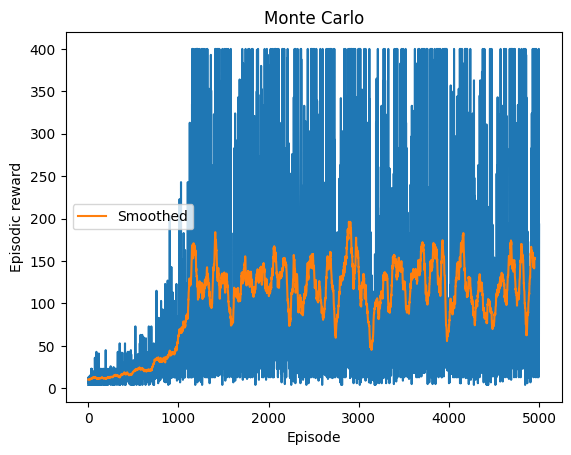

In [7]:
from matplotlib import pyplot as plt

plt.plot(list_episodic_rewards_mc)
plt.xlabel("Episode")
plt.ylabel("Episodic reward")
plt.title("Monte Carlo")

# Smooth the curve
window = 50
list_episodic_rewards_mc_smooth = np.convolve(list_episodic_rewards_mc, np.ones(window)/window, mode='valid')
plt.plot(list_episodic_rewards_mc_smooth, label="Smoothed")
plt.legend()
plt.show()

In [8]:
from algorithms.sarsa_lambda import SARSA_Lambda

config_sarsa_lambda = {
    "learning_rate": 0.1,
    "gamma": 0.99,
    "lmbda": 0.9,
    "do_replacing_traces": True,
    "threshold_deletion_traces": 0.0,
    "q_model": {
        "class_string": 'src.learners.tabular:QValuesTabularLearner',
        "method_q_value_initialization": "random",
        "typical_return": 1.0,
        "typical_return_std": 1.0
    },
    "method_exploration": "eps_greedy",
    "epsilon": {
        "class_string": "src.schedulers:Exponential",
        "start_value": 0.05,
        "end_value": 0.05,
        "n_steps": 5000,
        "lower_bound": 0.1
    },
}

algo_sarsa_lambda = SARSA_Lambda(config_sarsa_lambda)
 

In [9]:
list_episodic_rewards_sarsa_lambda = train_algo(env, algo_sarsa_lambda)


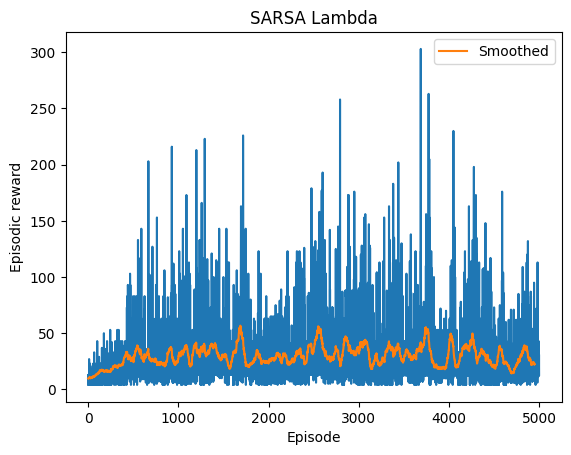

In [10]:
plt.plot(list_episodic_rewards_sarsa_lambda)
plt.xlabel("Episode")
plt.ylabel("Episodic reward")
plt.title("SARSA Lambda")

# Smooth the curve
window = 50
list_episodic_rewards_sarsa_lambda_smooth = np.convolve(list_episodic_rewards_sarsa_lambda, np.ones(window)/window, mode='valid')
plt.plot(list_episodic_rewards_sarsa_lambda_smooth, label="Smoothed")
plt.legend()
plt.show()